<img align="left" style="padding-right:10px;" src="https://cdn.goodq.top/caches/48c09dcfe95563ebd378e68c00243624/aHR0cDovL3d3dy5jaGVuLWxhYi5jbHViL3FmeS1jb250ZW50L3VwbG9hZHMvMjAxOS8wNC85MGM3MmVkNDVjNjYzZjI2NjYxN2Y4MmI4YzY0M2M4My5wbmc_p_p100_p_3D.png" width=5%>

*All data and algorithms in the notebook, and their updates can be obtained by visiting the following website：[SMF_S_Release](https://github.com/LicongLiu/SMF_S_Release)*

<center>
<h1>  </h1>
<h2> Example of SMFS </h2>
</center>
<h2> Contains:</h2>


1. What is SMFS?
2. Prerequisites
3. Reading image using GDAL
4. Showing our interesting area by Matplotlib
5. Preparing shape model
6. Vegetation timeseries preprocessing
7. Phenology detection
8. Saving detected result
9. Chaning the Windows Size

## 1. What is SMFS?

The SMFS method is a imporved shape model fitting based phenology detection algorithms.

In this example, we will guide step by step how to complete the phenology monitoring of an area through the SMFS algorithm. and how to change the window size to deal with noise.

## 2. Prerequisites

The following libraries are required to run the SMFS algorithm
* Numpy
* Numba

The following libraries are required to complete the entire notebook process
* GDAL python
* Scipy
* Matplotlib

## 3. Reading image using GDAL

<h>Firstly, we import the test EVI (Enhance Vegetation Index) image using the gdal library. The image located on a area of the North China Plain. The crops in this area are mainly winter wheat. This image has 500m spatial temporal resolution and 8-day temporal resolution, starting on August 1, 2007 and ending on August 1, 2008. </h>

<h>We also imported the winter wheat classification mapping data of the corresponding year.</h>

In [1]:
from osgeo import gdal
import os
os.chdir(r"D:\data\PhenologyMonitor\src\SMF_S\data")
dts = gdal.Open("winter_wheat_cover")
# get geographic coordinates
proj, geot = dts.GetProjection(), dts.GetGeoTransform()
# get winter wheat cover image
img_cover = dts.ReadAsArray()
# get EVI time series image
img_evi_ts = gdal.Open("EVI_2008").ReadAsArray() * 1e-4

print(img_cover.shape)
print(img_evi_ts.shape)

(400, 400)
(46, 400, 400)


## 4. Showing our interesting area

We can simply use matplotlib to initially show the area where we want to monitor phenology. And plot out some winter wheat EVI curves.

In [2]:
from random import randint
def random_a_point():
    while True:
        x, y = randint(0, 399), randint(0, 399)
        if img_cover[x, y] == 1:
            return x, y

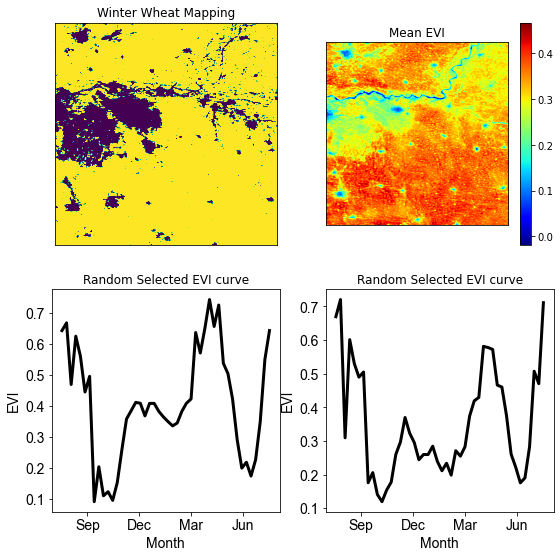

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import numpy as np
ticks_font = FontProperties(fname="C:\\Windows\\Fonts\\arial.ttf", size=14)

DOYs = np.arange(1, 366, 8)

plt.figure(figsize=(9, 9))

plt.subplot(221)
plt.title("Winter Wheat Mapping")
plt.imshow(img_cover, vmin=0.1, vmax=0.6)
plt.xticks([], []); plt.yticks([], [])


plt.subplot(222)
plt.title("Mean EVI")
plt.imshow(np.mean(img_evi_ts, axis=0), cmap="jet")
plt.xticks([], []); plt.yticks([], [])
plt.colorbar()

time_labels_4 = ["Sep", "Dec", "Mar", "Jun"]
time_xlength_4 = np.arange(45, 365, 90)

plt.subplot(223)
plt.title("Random Selected EVI curve")
p = random_a_point()
plt.plot(DOYs, img_evi_ts[:, p[0], p[1]], lw=3, c='k')
plt.xticks(time_xlength_4, time_labels_4, fontproperties=ticks_font)
plt.yticks(fontproperties=ticks_font)
plt.xlabel("Month", fontproperties=ticks_font)
plt.ylabel("EVI", fontproperties=ticks_font)

plt.subplot(224)
plt.title("Random Selected EVI curve")
p = random_a_point()
plt.plot(DOYs, img_evi_ts[:, p[0], p[1]], lw=3, c='k')
plt.xticks(time_xlength_4, time_labels_4, fontproperties=ticks_font)
plt.yticks(fontproperties=ticks_font)
plt.xlabel("Month", fontproperties=ticks_font)
plt.ylabel("EVI", fontproperties=ticks_font)
plt.show()

## 5. Preparing shape model

Next, we import the reference evi and reference phenology.

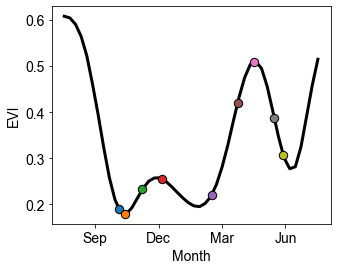

In [4]:
path_ref_evi = open('ref_evi.txt')
evi_ts_ref = []
for line in path_ref_evi.readlines():
    evi_ts_ref.append(float(line))
evi_ts_ref = np.array(evi_ts_ref)

path_ref_phe = open('ref_phe.txt')
phe_ref = []
for line in path_ref_phe.readlines():
    phe_ref.append(float(line))
phe_ref = np.array(phe_ref)

plt.figure(figsize=(5, 4))
plt.plot(DOYs, evi_ts_ref, lw=3, c='k')
plt.xticks(time_xlength_4, time_labels_4, fontproperties=ticks_font)
plt.yticks(fontproperties=ticks_font)
plt.xlabel("Month", fontproperties=ticks_font)
plt.ylabel("EVI", fontproperties=ticks_font)
for i in range(9):
    plt.scatter(phe_ref[i], np.interp(phe_ref[i], DOYs, evi_ts_ref), c="C{}".format(i), zorder=10, edgecolor='k', s=70)
plt.show()

## 6. Vegetation timeseries preprocessing

When extracting phenology, we usually filter the vegetation index curve. This can reduce the noise of the curve and improve the stability of the phenological extraction results.
We use Chen SG's algorithm to filter the EVI vegetation index curve.

In [5]:
import sys
sys.path.append("..")
from src.chensg import chen_sg_filter as cf

In [6]:
from tqdm import tqdm
img_evi_fts = np.copy(img_evi_ts)
xlen, ylen = img_cover.shape
for i in tqdm(range(xlen)):
    for j in range(ylen):
        img_evi_fts[:, i, j] = cf(img_evi_ts[:, i, j])

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:12<00:00, 32.71it/s]


*Note that the cfilter function is just a simplified version.
Please refer to this link to get original IDL chen sg algorithm:[chen-lab](http://www.chen-lab.club/)*

Next, we can take a look at the smoothed curve.

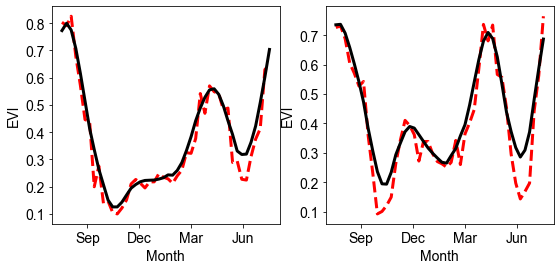

In [7]:
plt.figure(figsize=(9, 4))

plt.subplot(121)
p = random_a_point()
plt.plot(DOYs, img_evi_ts[:, p[0], p[1]], lw=3, c="r", ls='--')
plt.plot(DOYs, img_evi_fts[:, p[0], p[1]], lw=3, c="k", ls='-')

plt.xticks(time_xlength_4, time_labels_4, fontproperties=ticks_font)
plt.yticks(fontproperties=ticks_font)
plt.xlabel("Month", fontproperties=ticks_font)
plt.ylabel("EVI", fontproperties=ticks_font)

plt.subplot(122)
p = random_a_point()
plt.plot(DOYs, img_evi_ts[:, p[0], p[1]], lw=3, c="r", ls='--')
plt.plot(DOYs, img_evi_fts[:, p[0], p[1]], lw=3, c="k", ls='-')
plt.xticks(time_xlength_4, time_labels_4, fontproperties=ticks_font)
plt.yticks(fontproperties=ticks_font)
plt.xlabel("Month", fontproperties=ticks_font)
plt.ylabel("EVI", fontproperties=ticks_font)
plt.show()

Obviously, the smoothed curve is more beneficial to obtain phenology.
But in the real phenological extraction, we have to go to the next step, which is to erase both ends of the growing season for all winter wheat curves.
Because theoretically, the front end and the back end represent the vegetation curve changes of other crops.

In [8]:
from scipy.signal import argrelextrema
BREAK_POINTS = (90, 300)
def flatten(curve, doy=DOYs):
    minimal_locs = np.array(argrelextrema(curve, np.less_equal)).reshape(-1)
    locs = np.interp(BREAK_POINTS, doy, np.arange(46))
    first_mini = minimal_locs[np.argmin(np.abs(minimal_locs - locs[0]))]
    second_mini = minimal_locs[np.argmin(np.abs(minimal_locs - locs[1]))]
    curve = np.copy(curve)
    curve[:first_mini] = curve[first_mini]
    curve[second_mini:] = curve[second_mini]
    return curve

img_evi_ffts = np.copy(img_evi_fts)
for i in range(xlen):
    for j in range(ylen):
        if img_cover[i, j]:
            img_evi_ffts[:, i, j] = flatten(img_evi_fts[:, i, j])

Don't forget to smooth the reference curve as well.

In [9]:
evi_fts_ref = flatten(evi_ts_ref)

Let's see if the quality of the filtered vegetation index curve has improved.

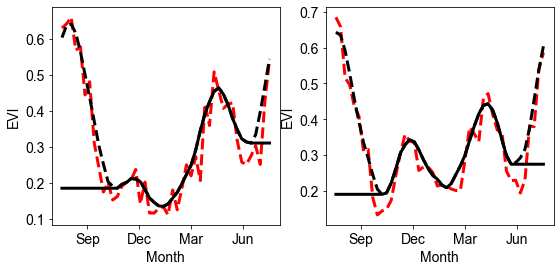

In [10]:
plt.figure(figsize=(9, 4))

plt.subplot(121)
p = random_a_point()
plt.plot(DOYs, img_evi_ts[:, p[0], p[1]], lw=3, c="r", ls="--")
plt.plot(DOYs, img_evi_fts[:, p[0], p[1]], lw=3, c="k", ls="--")
plt.plot(DOYs, img_evi_ffts[:, p[0], p[1]], lw=3, c="k", ls="-")
plt.xticks(time_xlength_4, time_labels_4, fontproperties=ticks_font)
plt.yticks(fontproperties=ticks_font)
plt.xlabel("Month", fontproperties=ticks_font)
plt.ylabel("EVI", fontproperties=ticks_font)

plt.subplot(122)
p = random_a_point()
plt.plot(DOYs, img_evi_ts[:, p[0], p[1]], lw=3, c="r", ls="--")
plt.plot(DOYs, img_evi_fts[:, p[0], p[1]], lw=3, c="k", ls="--")
plt.plot(DOYs, img_evi_ffts[:, p[0], p[1]], lw=3, c="k", ls="-")
plt.xticks(time_xlength_4, time_labels_4, fontproperties=ticks_font)
plt.yticks(fontproperties=ticks_font)
plt.xlabel("Month", fontproperties=ticks_font)
plt.ylabel("EVI", fontproperties=ticks_font)

plt.show()

## 7. Phenology detection

It can be seen that the vegetation index curve after SG filtering is smooth enough for the next step.

Now, we have prepared all the preliminaries for phenological extraction, and we can officially start the extraction.
Use the following method to call the smf_s functions to detect phenological periods.

To save time, we only calculated the emergence, greening-up and maturity stages here.
This may take 1 or 2 minutes, depending on your CPU performance.

In [11]:
from src.smf_s_class import SMFS
img_smfsphes = np.zeros((len(phe_ref), xlen, ylen))

In [12]:
# for phe_i in range(9): # Detect all phenology
for phe_i in (1, 4, 8): # Detect EMG, GUD and MAT
    smfs_model = SMFS(evi_fts_ref, phe_ref[phe_i], DOYs)
    for i in tqdm(range(xlen)):
        for j in range(ylen):
            if not img_cover[i, j]:
                continue
            img_smfsphes[phe_i, i, j] = smfs_model.doit(img_evi_ffts[:, i, j])

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:40<00:00,  9.77it/s]


Randomly select some points to see the performance of phenology monitor.

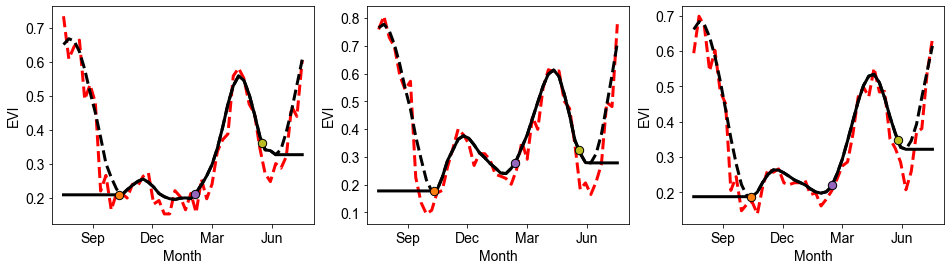

In [13]:
plt.figure(figsize=(16, 4))
for i_map in range(3):
    plt.subplot(1, 3, i_map + 1)
    p = random_a_point()
    p[0], p[1]
    
    plt.plot(DOYs, img_evi_ts[:, p[0], p[1]], lw=3, c="r", ls="--")
    plt.plot(DOYs, img_evi_fts[:, p[0], p[1]], lw=3, c="k", ls="--")
    plt.plot(DOYs, img_evi_ffts[:, p[0], p[1]], lw=3, c="k", ls="-")
    phe_detected = img_smfsphes[:, p[0], p[1]]
    for i in range(9):
        if phe_detected[i] == 0:
            continue
        plt.scatter(phe_detected[i], 
                    np.interp(phe_detected[i], DOYs, img_evi_ffts[:, p[0], p[1]]),
                    c='C{}'.format(i),
                    s=70,
                    zorder=10,
                    edgecolor='k')
    plt.xticks(time_xlength_4, time_labels_4, fontproperties=ticks_font)
    plt.yticks(fontproperties=ticks_font)
    plt.xlabel("Month", fontproperties=ticks_font)
    plt.ylabel("EVI", fontproperties=ticks_font)
plt.show()

Similarly, we can print out the regional phenology mapping results obtained by SMFS

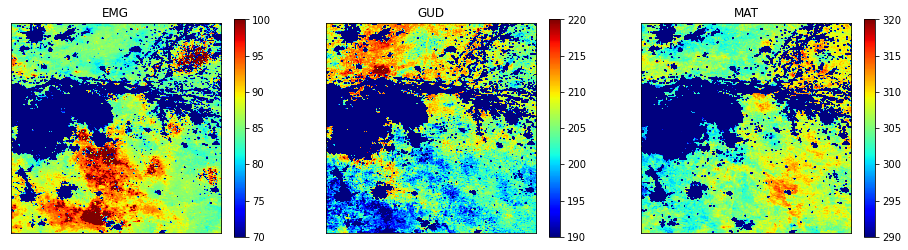

In [14]:
plt.figure(figsize=(16, 4))
plt.subplot(131)
plt.title("EMG")
plt.imshow(img_smfsphes[1, :, :], vmin=70, vmax=100, cmap="jet")
plt.xticks([], []); plt.yticks([], [])
plt.colorbar()

plt.subplot(132)
plt.title("GUD")
plt.imshow(img_smfsphes[4, :, :], vmin=190, vmax=220, cmap="jet")
plt.xticks([], []); plt.yticks([], [])
plt.colorbar()

plt.subplot(133)
plt.title("MAT")
plt.imshow(img_smfsphes[8, :, :], vmin=290, vmax=320, cmap="jet")
plt.xticks([], []); plt.yticks([], [])
plt.colorbar()
plt.show()

## 8. Saving detected result

Using the GDAL library, we can simply save the detection image.

In [15]:
img_smfsphes = img_smfsphes.astype("uint16")
gdal_type = 2 # uint16 in gda
im_band, im_height, im_width = img_smfsphes.shape
driver = gdal.GetDriverByName("GTiff")
dataset = driver.Create("Img_SMFS_Phenology.tif", im_width, im_height, im_band, gdal_type)
dataset.SetGeoTransform(geot)
dataset.SetProjection(proj)
for i in range(im_band):
    dataset.GetRasterBand(i + 1).WriteArray(img_smfsphes[i, :, :])
dataset = None

## 9. Chaning the Windows Size

The following code is used to demonstrate how to change the window length for SMFS. <br/> To do this, we're going to do a bold experiment. Let's try to use SMFS method detect the phenology on the vegetation index time series without any preprocess. </h>

To accomplish this, we empirically extend the window length to 75 to account for noise. \
At the same time, when no filtering is performed, the smoothness of the curve is greatly reduced, which will greatly reduce the final correlation coefficient. Therefore, we lower RTOL to 0, so we will not miss these detection result.

Note: Even though SMFS can be run on unsmoothed data, in practice, we still recommend to do filtering before detecting phenology.Because this will significantly improve the phenology detection accuracy.

In [16]:
# for phe_i in range(9): # Detect all phenology
for phe_i in (1, 4, 8): # Detect EMG, GUD and MAT
    smfs_model = SMFS(evi_ts_ref, phe_ref[phe_i], DOYs)
    smfs_model.WIN = 75  # Using this code to increase the windows size
    smfs_model.RTOL = 0  # Using this code to decrease R tolerance
    for i in tqdm(range(xlen)):
        for j in range(ylen):
            if not img_cover[i, j]:
                continue
            img_smfsphes[phe_i, i, j] = smfs_model.doit(img_evi_ts[:, i, j])

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:37<00:00, 10.74it/s]


Let's have a look!

*Note: You can run this line several times to show the results for different points.*

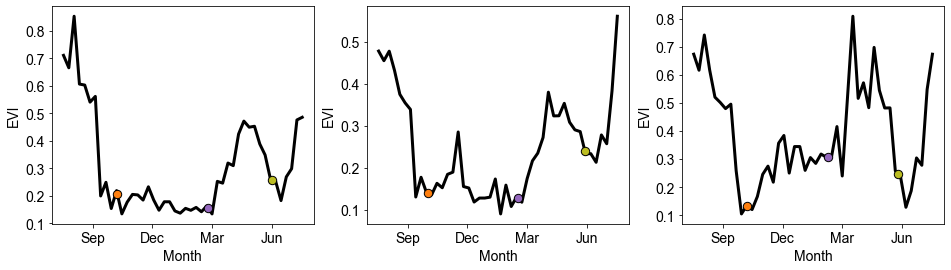

In [17]:
plt.figure(figsize=(16, 4))
for i_map in range(3):
    plt.subplot(1, 3, i_map + 1)
    p = random_a_point()
    p[0], p[1]
    plt.plot(DOYs, img_evi_ts[:, p[0], p[1]], c="k", lw=3)
    phe_detected = img_smfsphes[:, p[0], p[1]]
    for i in range(9):
        if phe_detected[i] == 0:
            continue
        plt.scatter(phe_detected[i], 
                    np.interp(phe_detected[i], DOYs, img_evi_ts[:, p[0], p[1]]),
                    c='C{}'.format(i),
                    s=70,
                    zorder=10,
                    edgecolor='k')
    plt.xticks(time_xlength_4, time_labels_4, fontproperties=ticks_font)
    plt.yticks(fontproperties=ticks_font)
    plt.xlabel("Month", fontproperties=ticks_font)
    plt.ylabel("EVI", fontproperties=ticks_font)
plt.show()

Here, we use the SMFS algorithm to complete the phenology extraction of the entire area. We also learned how to change the window size to deal with noise.

However, the window size 75 is empirically determined. In the next notebook (SMFS_S_Windows.ipynb), we provided a full demonstration of building a window size look-up table based on the noise level. [We are preparing it and will publish it soon]